In [1]:
import getpass
import os

# Prompt for the token
hf_token = getpass.getpass('Enter your HF access token and press enter: ')

# Set the environment variable
os.environ['HF_TOKEN'] = hf_token

print("HF_TOKEN environment variable has been set.")

Enter your HF access token and press enter:  ········


HF_TOKEN environment variable has been set.


In [2]:
import os
import sys
sys.path.append('/home/jovyan/dzinovev/ai-toolkit')
from collections import OrderedDict
from PIL import Image
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


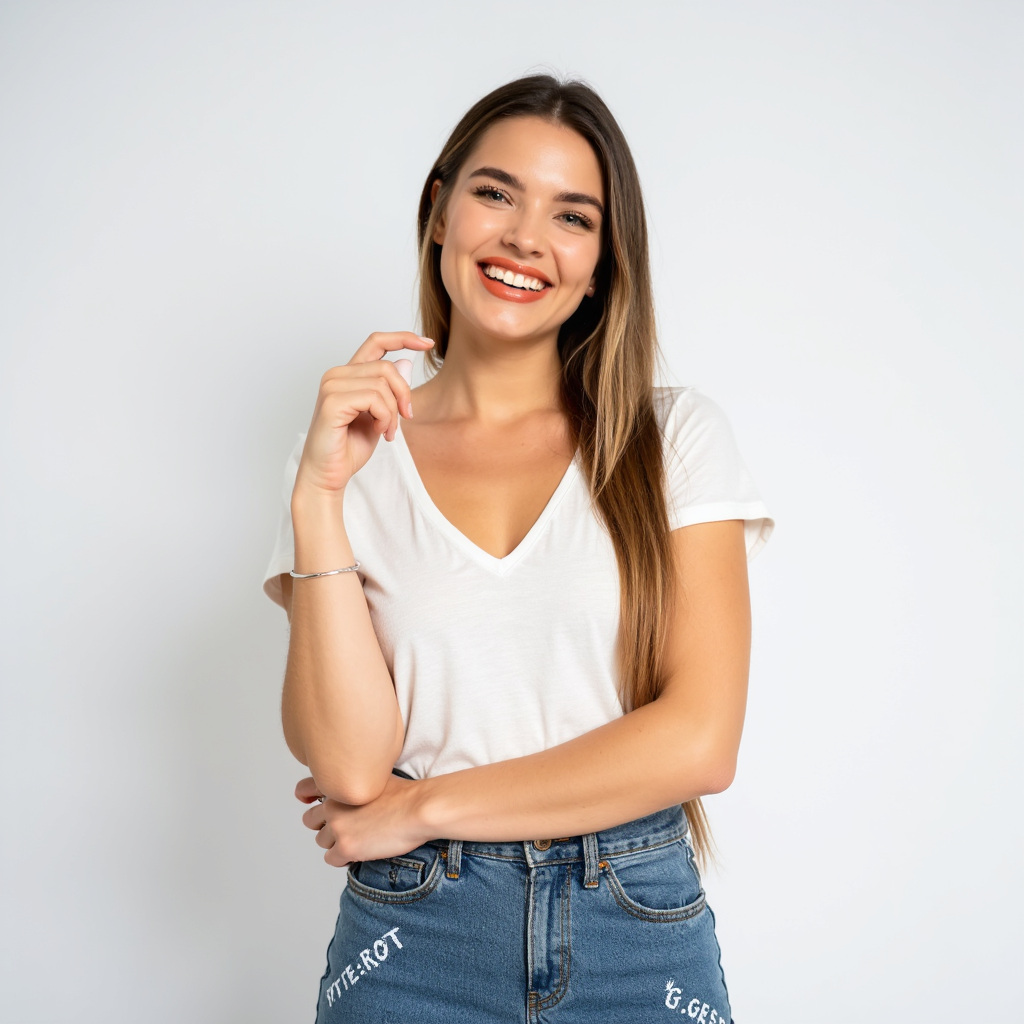

In [5]:
import torch
from diffusers import FluxPriorReduxPipeline, FluxPipeline
from diffusers import FluxControlPipeline
from image_gen_aux import DepthPreprocessor
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5TokenizerFast

from diffusers.utils import load_image
from PIL import Image
from huggingface_hub import hf_hub_download

path2person_lora = '<path to your lora>'

device = "cuda"
dtype = torch.bfloat16
text_encoder = CLIPTextModel.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    subfolder="text_encoder",
    torch_dtype=dtype,
)
text_encoder_2 = T5EncoderModel.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    subfolder="text_encoder_2",
    torch_dtype=dtype,
)
tokenizer = CLIPTokenizer.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    subfolder="tokenizer",
)
tokenizer_2 = T5TokenizerFast.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    subfolder="tokenizer_2",
)

repo_redux = "black-forest-labs/FLUX.1-Redux-dev"
repo_base = "black-forest-labs/FLUX.1-dev" 
pipe_prior_redux = FluxPriorReduxPipeline.from_pretrained(repo_redux, 
                                                          text_encoder=text_encoder,
                                                          text_encoder_2 = text_encoder_2,
                                                          tokenizer=tokenizer,
                                                          tokenizer_2=tokenizer_2,
                                                          torch_dtype=dtype).to(device)
pipe = FluxPipeline.from_pretrained(
    repo_base, 
    torch_dtype=torch.bfloat16
).to(device)
pipe.load_lora_weights('face_base_v1.safetensors', adapter_name='person')  # здесь надо заменить на новую лору человека
pipe.load_lora_weights('lora.safetensors', adapter_name='realism')
pipe.set_adapters(["person", "realism"], adapter_weights=[0.7, 0.3])
image = load_image("woman_image.png")
pipe_prior_output = pipe_prior_redux(image, prompt='person, realistic and nantural woman')
images = pipe(
    guidance_scale=2.5,
    num_inference_steps=50,
    generator=torch.Generator("cpu").manual_seed(0),
    **pipe_prior_output,
).images
images[0]